# VGG16 Retrain using custom layers

### Imports

In [21]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import cv2, numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from sklearn.metrics import confusion_matrix

### Setup Trainer

In [22]:
train_data_dir = "m_trn"
validation_data_dir = "m_val"
test_data_dir = "m_val"
nb_train_samples = 848 #1313
nb_validation_samples = 313 #454
batch_size = 20
epochs = 50

In [23]:
# plot images with labels
def plots(imgs, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(imgs[0]) is np.ndarray:
        imgs = np.array(imgs).astype(np.uint8)
        if (imgs.shape[-1]!=3):
            imgs = imgs.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs)%2 == 0 else len(imgs)//rows+1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        plt.imshow(imgs[i], interpolation=None if interp else 'none')

In [32]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=30
)

test_datagen = ImageDataGenerator(
rescale = 1./255,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=30
)

In [33]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(224,224),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size=(224,224),
class_mode = "categorical")

Found 848 images belonging to 10 classes.
Found 271 images belonging to 10 classes.


### Look at some Memes!

In [23]:
train_batches = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(224,224), batch_size=4)

Found 848 images belonging to 10 classes.


In [26]:
for (dirpath, dirnames, filenames) in os.walk('m_trn'):
    print(dirnames)
    meme_labels = dirnames
    break

['Art Classical', 'Cartoons', 'Comics Original', 'Doggo n Kitty', 'Drake', 'Escalating', 'Stock', 'Texts', 'Twitter FB Forums', 'World']


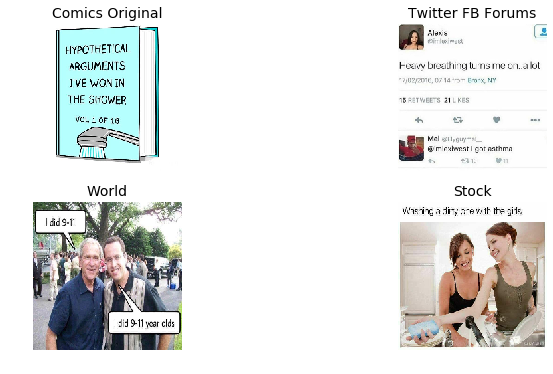

In [25]:
imgs, labels = next(train_batches)
c = []
for l in labels:
    for i in range(len(l)):
        if l[i]>0:
            c.append(meme_labels[i])
plots(imgs, titles=c)

### Build VGG16 Model

In [27]:
# vgg16_new_small.h5
# vgg16_weights_tf_dim_ordering_tf_kernels.h5
vgg_model = applications.vgg16.VGG16(weights = "vgg16_weights_tf_dim_ordering_tf_kernels.h5", include_top=True)
print('getting VGG16 model')
print(type(vgg_model))
model = Sequential()
for layer in vgg_model.layers[:-1]:
    model.add(layer)
model.summary()
print(type(model))

getting VGG16 model
<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv

In [28]:
for layer in model.layers:
    layer.trainable = False
print('freezing all layers')
model.add(Dense(10, activation="softmax", name='prediction'))
model.summary()

freezing all layers
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [29]:
model.compile(optimizers.Adam(lr=0.0001), loss = 'categorical_crossentropy',metrics=['accuracy'])

In [30]:
checkpoint = ModelCheckpoint("vgg16_new_small.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [34]:
model.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples//batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples//batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
42/42 [==============================] - 19s 441ms/step - loss: 1.9685 - acc: 0.3452 - val_loss: 1.8553 - val_acc: 0.3542

Epoch 00001: val_acc did not improve from 0.68251
Epoch 2/50
42/42 [==============================] - 15s 352ms/step - loss: 1.6538 - acc: 0.4501 - val_loss: 1.6918 - val_acc: 0.3834

Epoch 00002: val_acc did not improve from 0.68251
Epoch 3/50
42/42 [==============================] - 15s 352ms/step - loss: 1.5807 - acc: 0.4453 - val_loss: 1.6402 - val_acc: 0.4619

Epoch 00003: val_acc did not improve from 0.68251
Epoch 4/50
42/42 [==============================] - 15s 357ms/step - loss: 1.5097 - acc: 0.4714 - val_loss: 1.6357 - val_acc: 0.4708

Epoch 00004: val_acc did not improve from 0.68251
Epoch 5/50
42/42 [==============================] - 15s 353ms/step - loss: 1.4654 - acc: 0.5262 - val_loss: 1.5910 - val_acc: 0.4686

Epoch 00005: val_acc did not improve from 0.68251
Epoch 6/50
42/42 [==============================] - 15s 353ms/step - loss: 1.400

42/42 [==============================] - 15s 356ms/step - loss: 1.0346 - acc: 0.6709 - val_loss: 1.1522 - val_acc: 0.6076

Epoch 00045: val_acc did not improve from 0.68251
Epoch 46/50
42/42 [==============================] - 15s 361ms/step - loss: 1.0015 - acc: 0.6821 - val_loss: 1.1619 - val_acc: 0.6048

Epoch 00046: val_acc did not improve from 0.68251
Epoch 47/50
42/42 [==============================] - 15s 351ms/step - loss: 1.0002 - acc: 0.6703 - val_loss: 1.1691 - val_acc: 0.5942

Epoch 00047: val_acc did not improve from 0.68251
Epoch 48/50
42/42 [==============================] - 15s 352ms/step - loss: 1.0845 - acc: 0.6454 - val_loss: 1.1601 - val_acc: 0.6256

Epoch 00048: val_acc did not improve from 0.68251
Epoch 49/50
42/42 [==============================] - 15s 357ms/step - loss: 1.0037 - acc: 0.6858 - val_loss: 1.1834 - val_acc: 0.5745

Epoch 00049: val_acc did not improve from 0.68251
Epoch 50/50
42/42 [==============================] - 14s 340ms/step - loss: 0.9830 - ac

## Test Model

- vgg16_new_small.h5
- vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [16]:
from keras.models import load_model
model = load_model("vgg16_new_small.h5")

In [17]:
test_batches = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(224,224), batch_size=8)

Found 271 images belonging to 10 classes.


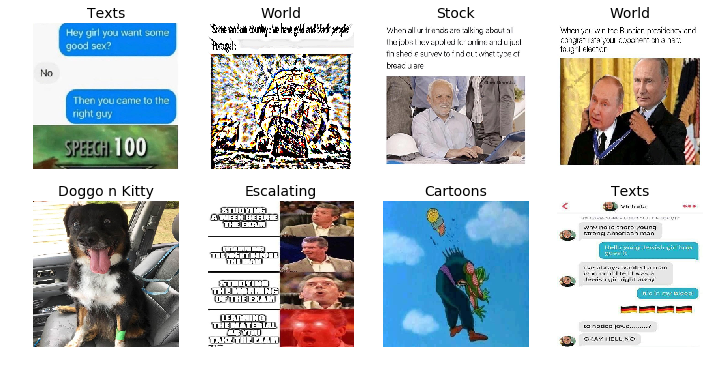

In [18]:
imgs, labels = next(test_batches)
c = []
for l in labels:
    for i in range(len(l)):
        if l[i]>0:
            c.append(meme_labels[i])
plots(imgs, titles=c)

In [20]:
pred = model.predict_generator(test_batches, steps=4, verbose=1)
pred = np.round(pred)
d = []
for l in pred:
    for i in range(len(l)):
        if l[i]>0:
            d.append(meme_labels[i])
pred

4/4 [==============================] - 0s 60ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 